# General information

Example colab for SigLIP models described in [the SigLIP paper](https://arxiv.org/abs/2303.15343).

**These models are not official Google products and were trained and released for research purposes.**

If you find our model(s) useful for your research, consider citing

```
@article{zhai2023sigmoid,
  title={Sigmoid loss for language image pre-training},
  author={Zhai, Xiaohua and Mustafa, Basil and Kolesnikov, Alexander and Beyer, Lucas},
  journal={International Conference on Computer Vision ({ICCV})},
  year={2023}
}
```

If you use our released models in your products, we will appreciate any direct feedback. We are reachable by xzhai@google.com, basilm@google.com, akolesnikov@google.com and lbeyer@google.com.


Only the models explicitly marked with `i18n` in the name are expected to perform reasonably well on non-english data.

In [1]:
#@markdown # Environment setup
#@markdown **IMPORTANT NOTE**: Modern jax (>0.4) does not support the Colab TPU
#@markdown anymore, so don't select TPU runtime here. CPU and GPU work and are both fast enough.

# Install the right jax version for TPU/GPU/CPU
import os
if 'COLAB_TPU_ADDR' in os.environ:
  raise "TPU colab not supported."
elif 'NVIDIA_PRODUCT_NAME' in os.environ:
  !nvidia-smi
import jax
jax.devices()


# Get latest version of big_vision codebase.
!git clone --quiet --branch=main --depth=1 https://github.com/google-research/big_vision
!cd big_vision && git pull --rebase --quiet
!pip -q install -r big_vision/big_vision/requirements.txt
# Gives us ~2x faster gsutil cp to get the model checkpoints.
!pip3 -q install --no-cache-dir -U crcmod

%cd big_vision


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax
import jax.numpy as jnp
import ml_collections

from google.colab.output import _publish as publish

Thu Sep 28 09:08:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Choose and load model, perform inference

In [2]:
# Pick your hero: (WHEN CHANGING THIS, RERUN IMAGE/TEXT EMBEDDING CELLS)
# Give this cell 1-3mins.

# VARIANT, RES = 'B/16', 224
# VARIANT, RES = 'B/16', 256
# VARIANT, RES = 'B/16', 384
# VARIANT, RES = 'B/16', 512
# VARIANT, RES = 'L/16', 256
VARIANT, RES = 'L/16', 384
# VARIANT, RES = 'So400m/14', 224
# VARIANT, RES = 'So400m/14', 384
# VARIANT, RES = 'B/16-i18n', 256

CKPT, TXTVARIANT, EMBDIM, SEQLEN, VOCAB = {
    ('B/16', 224): ('webli_en_b16_224_63724782.npz', 'B', 768, 64, 32_000),
    ('B/16', 256): ('webli_en_b16_256_60500360.npz', 'B', 768, 64, 32_000),
    ('B/16', 384): ('webli_en_b16_384_68578854.npz', 'B', 768, 64, 32_000),
    ('B/16', 512): ('webli_en_b16_512_68580893.npz', 'B', 768, 64, 32_000),
    ('L/16', 256): ('webli_en_l16_256_60552751.npz', 'L', 1024, 64, 32_000),
    ('L/16', 384): ('webli_en_l16_384_63634585.npz', 'L', 1024, 64, 32_000),
    ('So400m/14', 224): ('webli_en_so400m_224_57633886.npz', 'So400m', 1152, 16, 32_000),
    ('So400m/14', 384): ('webli_en_so400m_384_58765454.npz', 'So400m', 1152, 64, 32_000),
    ('B/16-i18n', 256): ('webli_i18n_b16_256_66117334.npz', 'B', 768, 64, 250_000),
}[VARIANT, RES]

# It is significantly faster to first copy the checkpoint (30s vs 8m30 for B and 1m vs ??? for L)
!test -f /tmp/{CKPT} || gsutil cp gs://big_vision/siglip/{CKPT} /tmp/

if VARIANT.endswith('-i18n'):
  VARIANT = VARIANT[:-len('-i18n')]

import big_vision.models.proj.image_text.two_towers as model_mod

model_cfg = ml_collections.ConfigDict()
model_cfg.image_model = 'vit'  # TODO(lbeyer): remove later, default
model_cfg.text_model = 'proj.image_text.text_transformer'  # TODO(lbeyer): remove later, default
model_cfg.image = dict(variant=VARIANT, pool_type='map')
model_cfg.text = dict(variant=TXTVARIANT, vocab_size=VOCAB)
model_cfg.out_dim = (None, EMBDIM)  # (image_out_dim, text_out_dim)
model_cfg.bias_init = -10.0
model_cfg.temperature_init = 10.0

model = model_mod.Model(**model_cfg)

# Using `init_params` is slower but will lead to `load` below performing sanity-checks.
# init_params = jax.jit(model.init, backend="cpu")(jax.random.PRNGKey(42), jnp.zeros([1, RES, RES, 3], jnp.float32), jnp.zeros([1, SEQLEN], jnp.int32))['params']
init_params = None  # Faster but bypasses loading sanity-checks.

params = model_mod.load(init_params, f'/tmp/{CKPT}', model_cfg)

Copying gs://big_vision/siglip/webli_i18n_b16_256_66117334.npz...
- [1 files][  1.3 GiB/  1.3 GiB]   45.3 MiB/s                                   
Operation completed over 1 objects/1.3 GiB.                                      


In [10]:
#@title Load and embed images

import big_vision.pp.builder as pp_builder
import big_vision.pp.ops_general
import big_vision.pp.ops_image
import big_vision.pp.ops_text
import PIL

!wget -q https://cdn.openai.com/multimodal-neurons/assets/apple/apple-ipod.jpg
!wget -q https://cdn.openai.com/multimodal-neurons/assets/apple/apple-blank.jpg
!wget -q 'https://images.unsplash.com/photo-1566467021888-b03548769dd1?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&dl=svetlana-gumerova-hQHm2D1fH70-unsplash.jpg&w=640' -O cold_drink.jpg
!wget -q 'https://images.rawpixel.com/image_1300/czNmcy1wcml2YXRlL3Jhd3BpeGVsX2ltYWdlcy93ZWJzaXRlX2NvbnRlbnQvbHIvdXB3azU4ODU5NzY1LXdpa2ltZWRpYS1pbWFnZS1rb3diMmhkeC5qcGc.jpg' -O hot_drink.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/authors.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/siglip.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/caffeine.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/robosign.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/fried_fish.jpeg
!wget -q 'https://pbs.twimg.com/media/FTyEyxyXsAAyKPc?format=jpg&name=small' -O cow_beach.jpg
!wget -q 'https://storage.googleapis.com/big_vision/siglip/cow_beach2.jpg' -O cow_beach2.jpg
!wget -q 'https://pbs.twimg.com/media/Frb6NIEXwAA8-fI?format=jpg&name=medium' -O mountain_view.jpg


images = [PIL.Image.open(fname) for fname in [
    'apple-ipod.jpg',
    'apple-blank.jpg',
    'cold_drink.jpg',
    'hot_drink.jpg',
    'caffeine.jpg',
    'siglip.jpg',
    'authors.jpg',
    'robosign.jpg',
    'cow_beach.jpg',
    'cow_beach2.jpg',
    'mountain_view.jpg',
]]

pp_img = pp_builder.get_preprocess_fn(f'resize({RES})|value_range(-1, 1)')
imgs = np.array([pp_img({'image': np.array(image)})['image'] for image in images])
zimg, _, out = model.apply({'params': params}, imgs, None)

print(imgs.shape, zimg.shape)

(11, 384, 384, 3) (11, 1024)


In [11]:
#@title Tokenize and embed texts

texts = [
    'an apple',
    'a picture of an apple',
    'an ipod',
    'granny smith',
    'an apple with a note saying "ipod"',
    'a cold drink on a hot day',
    'a hot drink on a cold day',
    'a photo of a cold drink on a hot day',
    'a photo of a hot drink on a cold day',
    #
    'a photo of two guys in need of caffeine',
    'a photo of two guys in need of water',
    'a photo of the SigLIP authors',
    'a photo of a rock band',
    'a photo of researchers at Google Brain',
    'a photo of researchers at OpenAI',
    #
    'a robot on a sign',
    'a photo of a robot on a sign',
    'an empty street',
    'autumn in Toronto',
    'a photo of autumn in Toronto',
    'a photo of Toronto in autumn',
    'a photo of Toronto in summer',
    'autumn in Singapore',
    #
    'cow',
    'a cow in a tuxedo',
    'a cow on the beach',
    'a cow in the prairie',
    #
    'the real mountain view',
    'Zürich',
    'San Francisco',
    'a picture of a laptop with the lockscreen on, a cup of cappucino, salt and pepper grinders. The view through the window reveals lake Zürich and the Alps in the background of the city.',
]

TOKENIZERS = {
    32_000: 'c4_en',
    250_000: 'mc4',
}
pp_txt = pp_builder.get_preprocess_fn(f'tokenize(max_len={SEQLEN}, model="{TOKENIZERS[VOCAB]}", eos="sticky", pad_value=1, inkey="text")')
txts = np.array([pp_txt({'text': text})['labels'] for text in texts])
_, ztxt, out = model.apply({'params': params}, None, txts)

print(txts.shape, ztxt.shape)

(31, 64) (31, 1024)


In [12]:
# This is how to get all probabilities:
print(f"Learned temperature {out['t'].item():.1f}, learned bias: {out['b'].item():.1f}")
probs = jax.nn.sigmoid(zimg @ ztxt.T * out['t'] + out['b'])
print(f"{probs[0][0]:.1%} that image 0 is '{texts[0]}'")
print(f"{probs[0][1]:.1%} that image 0 is '{texts[1]}'")

Learned temperature 118.2, learned bias: -12.7
10.4% that image 0 is 'an apple'
42.8% that image 0 is 'a picture of an apple'


In [7]:
# @title Pretty demo (code)
from IPython.display import Javascript

DEMO_IMG_SIZE = 96

import base64
import io

def bv2rgb(bv_img):
  return (bv_img * 127.5 + 127.5).astype(np.uint8)

def html_img(*, enc_img=None, pixels=None, id=None, size=100, max_size=None, max_height=None, style=""):
  if enc_img is None and pixels is not None:
    with io.BytesIO() as buf:
      PIL.Image.fromarray(np.asarray(pixels)).save(buf, format="JPEG")
      enc_img = buf.getvalue()

  img_data = base64.b64encode(np.ascontiguousarray(enc_img)).decode('ascii')

  id_spec = f'id={id}' if id else ''
  if size is not None:
    style_spec = f'style="{style}; width: {size}px; height: {size}px"'
  elif max_size is not None:
    style_spec = f'style="{style}; width: auto; height: auto; max-width: {max_size}px; max-height: {max_size}px;"'
  elif max_height is not None:
    style_spec = f'style="{style}; object-fit: cover; width: auto; height: {max_height}px;"'
  else: style_spec = ''

  return f'<img {id_spec} {style_spec} src="data:image/png;base64,{img_data}"/>'


def make_table(zimg, ztxt, out):
  # The default learnable bias is a little conservative. Play around with it!
  t, b = out['t'].item(), out['b'].item()
  tempered_logits = zimg @ ztxt.T * t
  probs = 1 / (1 + np.exp(-tempered_logits - b))
  publish.javascript(f"var logits = {tempered_logits.tolist()};")

  def color(p):
    return mpl.colors.rgb2hex(mpl.cm.Greens(p / 2)) if p >= 0.01 else "transparent"

  publish.javascript(f"var cmap = {[color(x) for x in np.linspace(0, 1, 50)]};")
  def cell(x, iimg, itxt):
    return f"<td id=td_{iimg}_{itxt} style=background-color:{color(x)} class=pct><pre id=p_{iimg}_{itxt}>{x * 100:>4.0f}%</pre>"

  html = f'''
  <p>
  <label for=b>Bias value:</label>
  <input id=b type=range min=-15 max=0 step=0.1 name=b value={b} style=vertical-align:middle>
  <output id=value></output>
  </p>
  '''

  html += "<table>\n"
  html += "<tr>"
  html += "".join([f"<td style='width:{DEMO_IMG_SIZE}px;line-height:0'>" + html_img(pixels=bv2rgb(img), size=DEMO_IMG_SIZE) for img in imgs])
  html += "<td>"
  for itxt, txt in enumerate(texts):
    html += f"<tr>" + "".join([cell(probs[iimg, itxt], iimg, itxt) for iimg in range(len(imgs))]) + f"<td class=txt>{txt}"

  publish.css(r"""
  table {
    border-collapse: collapse;
  }

  tr {
    border: 1px transparent;
  }

  tr:nth-child(odd) {
    background-color: #F5F5F5;
  }

  tr:hover {
    background-color: lightyellow;
    border: 1px solid black;
  }

  td.pct {
    text-align: center;
  }
  """)
  publish.html(html)

  # JS code to compute and write all probs from the logits.
  display(Javascript('''
  function update(b) {
    for(var iimg = 0; iimg < logits.length; iimg++) {
      for(var itxt = 0; itxt < logits[iimg].length; itxt++) {
        const el = document.getElementById(`p_${iimg}_${itxt}`);
        const p = Math.round(100 / (1 + Math.exp(-logits[iimg][itxt] - b)));
        const pad = p < 10.0 ? '  ' : p < 100.0 ? ' ' : ''
        el.innerHTML = pad + (p).toFixed(0) + '%';

        const td = document.getElementById(`td_${iimg}_${itxt}`);
        const c = cmap[Math.round(p / 100 * (cmap.length - 1))];
        td.style.backgroundColor = c;
      }
    }
  }
  '''))

  # JS code to connect the bias value slider
  display(Javascript('''
  const value = document.querySelector("#value");
  const input = document.querySelector("#b");
  value.textContent = input.value;
  input.addEventListener("input", (event) => {
    value.textContent = event.target.value;
    update(event.target.value);
  });
  '''))

  # Make the cell output as large as the table to avoid annoying scrollbars.
  display(Javascript(f'update({b})'))
  display(Javascript('google.colab.output.resizeIframeToContent()'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


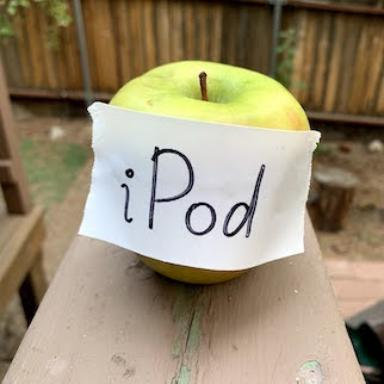
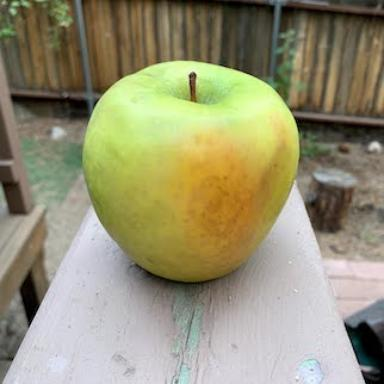
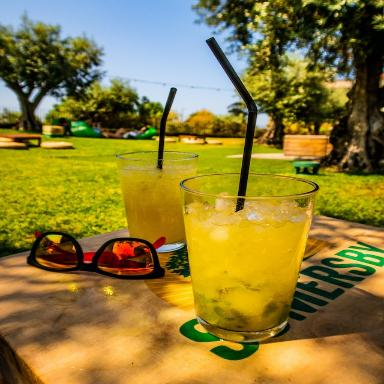
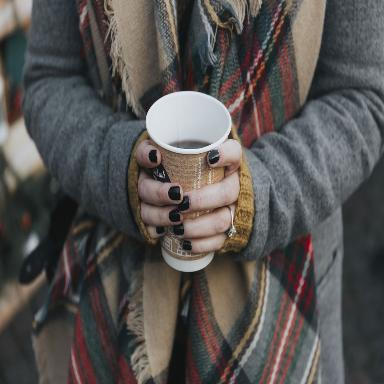
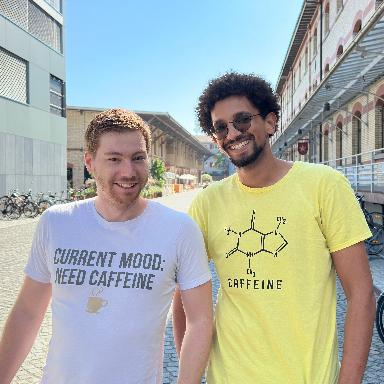
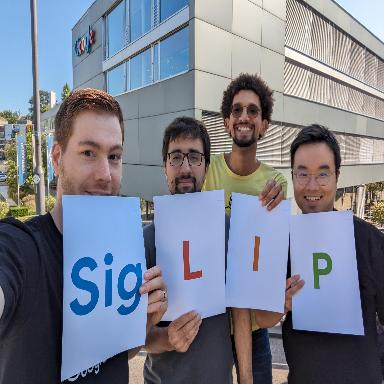
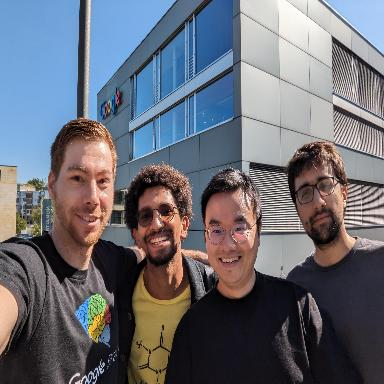
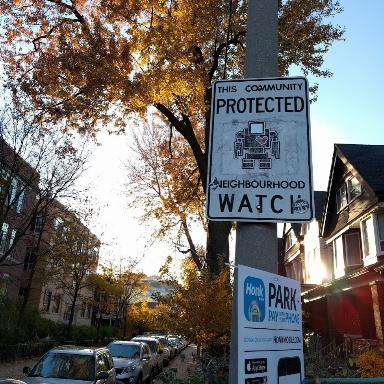
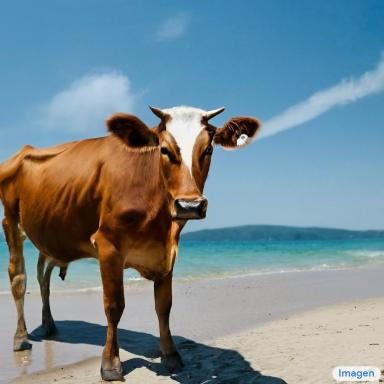
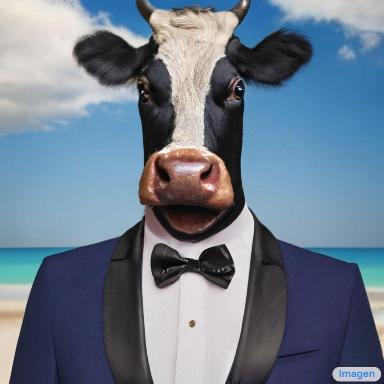
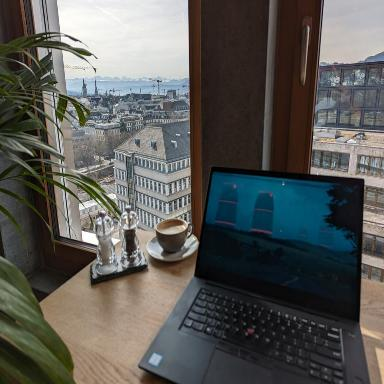

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
make_table(zimg, ztxt, out)

# More international examples (choose i18n model for this)

In [4]:
#@title Load and embed images

import big_vision.pp.builder as pp_builder
import big_vision.pp.ops_general
import big_vision.pp.ops_image
import big_vision.pp.ops_text
import PIL

!wget -q 'https://live.staticflickr.com/4152/5189547658_3b2a7126cb_b.jpg' -O ants_climbing_a_tree_food.jpg
!wget -q 'https://storage.googleapis.com/big_vision/siglip/pexels-poranimm-athithawatthee-842401.jpg' -O ants_climbing_tree.jpg
!wget -q 'https://images.rawpixel.com/image_1300/cHJpdmF0ZS9zdGF0aWMvaW1hZ2Uvd2Vic2l0ZS8yMDIyLTA0L2xyL3B4OTE3NDYyLWltYWdlLWt3eW8ydmxrLmpwZw.jpg' -O lion_head.jpg
!wget -q 'https://images.rawpixel.com/image_1300/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIzLTA5L3Jhd3BpeGVsX29mZmljZV8yN19taW5pbWFsX3NpbXBsZV9fbGlvbl9fcGFwZXJfY29sbGFnZV9taW5pbWFsX183OGRlOGU3OS02ZTE3LTQ2YzAtYTUyOS02ZDAxM2YzNDg0OWVfMi5qcGc.jpg' -O lion_head_red.jpg
!wget -q https://live.staticflickr.com/232/551040940_87299a85ec_h.jpg -O meat_ball.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/squirrel_fish.jpg -O squirrel_fish.jpg
!wget -q 'https://ideogram.ai/api/images/direct/F3lMxBprSk6ligq5Vy3XSw' -O squirrel_fish2.jpg
!wget -q 'https://pbs.twimg.com/media/FTyEyxyXsAAyKPc?format=jpg&name=small' -O cow_beach.jpg
!wget -q 'https://storage.googleapis.com/big_vision/siglip/cow_beach2.jpg' -O cow_beach2.jpg


images = [PIL.Image.open(fname) for fname in [
    'ants_climbing_a_tree_food.jpg',
    'ants_climbing_tree.jpg',
    'meat_ball.jpg',
    'lion_head.jpg',
    'lion_head_red.jpg',
    'fried_fish.jpeg',
    'squirrel_fish.jpg',
    'squirrel_fish2.jpg',
    'cow_beach.jpg',
    'cow_beach2.jpg',
]]

pp_img = pp_builder.get_preprocess_fn(f'resize({RES})|value_range(-1, 1)')
imgs = np.array([pp_img({'image': np.array(image)})['image'] for image in images])
zimg, _, out = model.apply({'params': params}, imgs, None)

print(imgs.shape, zimg.shape)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


(10, 256, 256, 3) (10, 768)


In [5]:
#@title Tokenize and embed texts

texts = [
    '蚂蚁上树',
    '肉末粉丝',
    'ants climbing a tree',
    'minced pork rice noodle',
    #
    '红烧狮子头',
    'red burned lion head',
    'lion head',
    'meat ball with soy sauce',
    #
    '松鼠鳜鱼',
    'squirrel',
    'squirrel and fish',
    'squirrel mandarinfish',
    'squirrel mandarin fish',
    'sweet and sour mandarin fish',
    #
    'cow',
    'a cow in a tuxedo',
    'a cow on the beach',
    'a cow in the prairie',
    'une vache sur la plage',
    'eine Kuh am Strand',
    'วัวอยู่ที่ชายหาด',
    '一只躺在沙滩上的牛',
    '一只沙滩上的牛',
    'корова на пляже',
    'بقرة على الشاطئ',
]

TOKENIZERS = {
    32_000: 'c4_en',
    250_000: 'mc4',
}
pp_txt = pp_builder.get_preprocess_fn(f'tokenize(max_len={SEQLEN}, model="{TOKENIZERS[VOCAB]}", eos="sticky", pad_value=1, inkey="text")')
txts = np.array([pp_txt({'text': text})['labels'] for text in texts])
_, ztxt, out = model.apply({'params': params}, None, txts)

print(txts.shape, ztxt.shape)

(25, 64) (25, 768)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


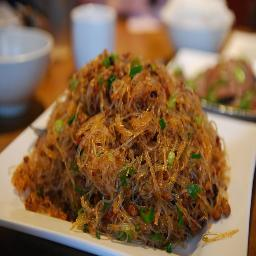
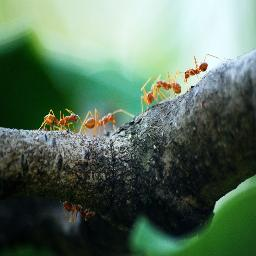
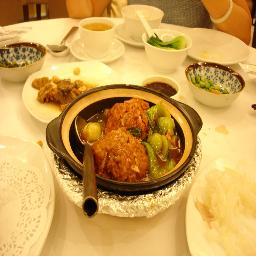
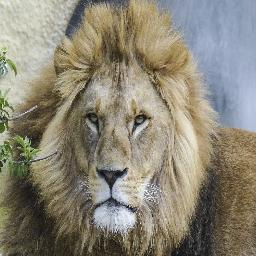
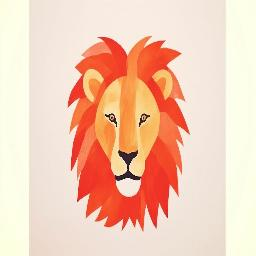
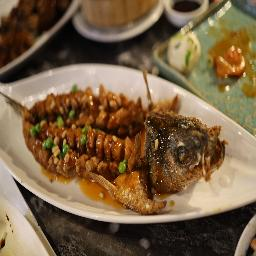
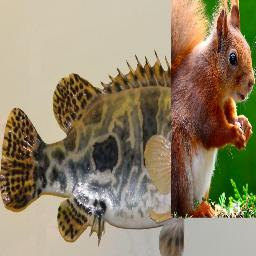
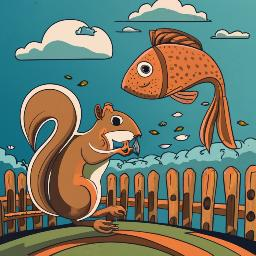
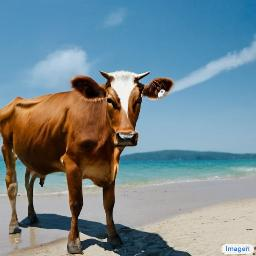
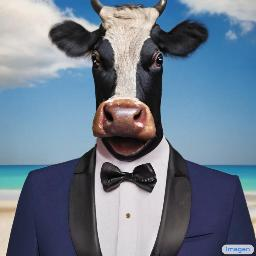

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
make_table(zimg, ztxt, out)

Explanation for non-Chinese speakers:

- The first dish is literally called "ants climbing a tree" in Chinese.
- The second dish is literally called "red burned lion head" in Chinese.
- The third dish is literally called "squirrel mandarinfish" in Chinese.

We are looking for more interesting examples that highlight culture-language aspects and where a non-EN model should "get it" while an EN-only does not.

# Example image credits

- The apple and apple + iPod images are from OpenAI.
- [Cold drink on hot day](https://unsplash.com/fr/photos/hQHm2D1fH70).
- [Hot drink on cold day](https://www.rawpixel.com/image/3282934).
- Cows on beach were created by Chitwan Saharia using the Imagen model and shared with permission.
- ["ant climbing tree" noodles](https://www.flickr.com/photos/avlxyz/5189547658)
- [actual ants climbing on a tree](https://www.pexels.com/photo/macro-photo-of-five-orange-ants-842401/)
- [real lion head](https://www.rawpixel.com/image/5941715/free-public-domain-cc0-photo)
- [cartoon red lion head](https://www.rawpixel.com/image/12447997/image-texture-paper-png)
- Collaged [squirrel](https://www.pexels.com/photo/brown-squirrel-47547/) and [fish](https://zh.wikipedia.org/zh-hans/%E9%B3%9C%E9%B1%BC) images.
- cartoon [squirrel and fish](https://ideogram.ai/g/zgoma01ASS21U1YwIC7MrA/2) generated by [ideogram.ai](http://ideogram.ai) [with permission](https://x.com/ideogram_ai/status/1697428471184515316?s=20).
- The remaining pictures are personal photos taken by the authors, long after the models were trained.